# DDoS ATTACK DETECTION PROJECT
This project simulates DDoS attacks and logs detected attacks to a CSV file. In this notebook, we will analyze the attack data and generate relevant insights.

In [1]:
# Before launching the Jupyter notebook, make sure you have all the package installed ! (Use pip)
# Importing necessary libraries

import pandas as pd  
import matplotlib.pyplot as plt  
import requests  
from datetime import datetime  
import cartopy.crs as ccrs  # For plotting geographical data
import cartopy.feature as cfeature  
import folium  # For creating interactive maps
import seaborn as sns  # For advanced data visualization


In [2]:
# Specify header=None to indicate that the CSV file has no headers
df_attacks = pd.read_csv('SniffnDetect/attack_log.csv', header=None)

# Manually assign column names
df_attacks.columns = ['Timestamp', 'Source IP', 'Destination IP', 'Attack Type', 'Packet Size']

# Check the dataframe
df_attacks.head()


,Timestamp,Source IP,Destination IP,Attack Type,Packet Size
0,1729463493.922295,192.168.1.178,223.62.134.80,POD,1514.0
1,1729463493.931003,192.168.1.178,170.113.54.46,POD,1514.0
2,1729463493.946776,192.168.1.178,150.153.46.11,POD,1514.0
3,1729463493.971087,192.168.1.178,96.162.203.117,POD,1514.0
4,1729463493.984839,192.168.1.178,147.89.217.130,POD,1514.0


## Most Common Types of DDoS Attacks
In this section, we will count and visualize the most common types of DDoS attacks in the log.

C:\Users\bumba\AppData\Local\Temp\ipykernel_8160\96255731.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attack_count.index, y=attack_count.values, palette='viridis')  # Use seaborn to plot a bar chart


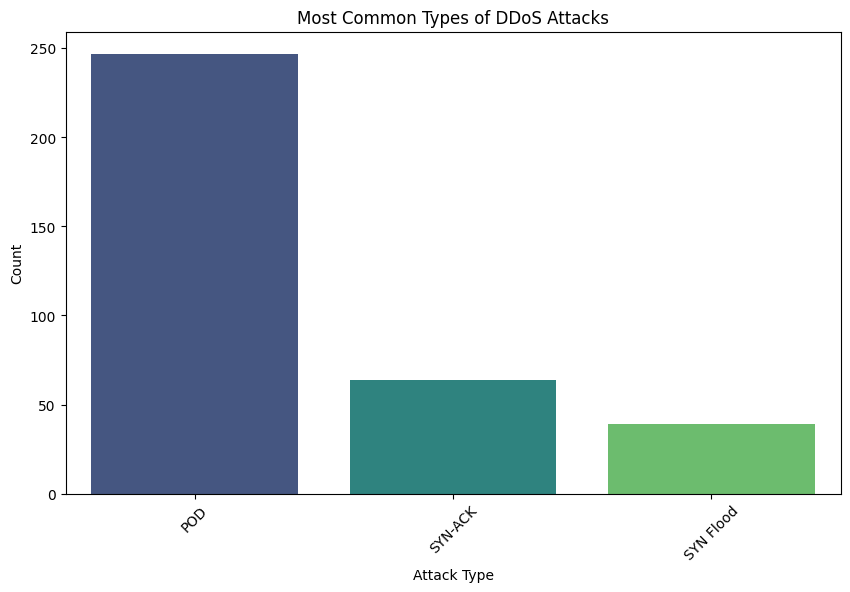

In [3]:
# Count the occurrences of each attack type
attack_count = df_attacks['Attack Type'].value_counts()

# Create a bar plot to visualize the most common types of DDoS attacks
plt.figure(figsize=(10,6))  
sns.barplot(x=attack_count.index, y=attack_count.values, palette='viridis')  # Use seaborn to plot a bar chart

# Add labels and title to the plot
plt.title('Most Common Types of DDoS Attacks')  
plt.xlabel('Attack Type')  
plt.ylabel('Count') 
plt.xticks(rotation=45)  

plt.show()


## Attack Locations by Source IP
Next, we will use the `ip-api.com` API to get the geographical locations of the source IP addresses and display them on a map.

In [4]:
# Function to get the geographical location of a given IP address using the ip-api.com API
def get_ip_location(ip):
    # Build the URL to request location data for the provided IP address
    url = f'http://ip-api.com/json/{ip}'
    try:
        # Send a GET request to the API
        response = requests.get(url)
        
        # Convert the response to JSON format
        data = response.json()
        
        # Print the full response for debugging purposes (to see what the API returns)
        print(f"Response: {data}")
        
        # If the API status is successful, return the latitude, longitude, city, and country
        if data['status'] == 'success':
            return data['lat'], data['lon'], data['city'], data['country']
        else:
            print(f"Error: {data.get('message', 'No message')}")
            return None
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None

example_ip = '4.4.4.4' 

# Get and print the location data for the IP
location = get_ip_location(example_ip)
print(location)


Response: {'status': 'success', 'country': 'United States', 'countryCode': 'US', 'region': 'HI', 'regionName': 'Hawaii', 'city': 'Honolulu', 'zip': '96805', 'lat': 21.3069, 'lon': -157.858, 'timezone': 'Pacific/Honolulu', 'isp': 'Level 3 Communications, Inc.', 'org': 'Level 3', 'as': 'AS3356 Level 3 Parent, LLC', 'query': '4.4.4.4'}
(21.3069, -157.858, 'Honolulu', 'United States')


## Visualization of Attack Origins on a Map
We will plot the locations of attacks on an interactive map using `folium`.

In [5]:
import time
import ipaddress
import folium

# Function to check if an IP address is private (e.g., 192.168.x.x)
def is_private_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except ValueError:
        return False  # Handle invalid IP addresses

# Set the center of the map
map_center = [20, 0]
attack_map = folium.Map(location=map_center, zoom_start=2)

# Make sure the sample size doesn't exceed the number of rows in the DataFrame
sample_size = min(len(df_attacks), 100)

# Sample a random subset of the DataFrame (for example, up to 100 random entries)
df_sample = df_attacks.sample(sample_size)

# Loop through the sampled attack entries
for index, row in df_sample.iterrows():
    ip = row['Source IP']
    
    # Skip private IP addresses
    if is_private_ip(ip):
        print(f"Skipping private IP: {ip}")
        continue
    
    # Fetch the IP's location using an API call
    location = get_ip_location(ip)
    
    if location:
        lat, lon, city, country = location
        print(f"Adding marker for {ip}: {lat}, {lon}, {city}, {country}")
        # Add a marker to the map
        folium.Marker(location=[lat, lon], popup=f"{ip} - {city}, {country}").add_to(attack_map)
    else:
        print(f"Failed to get location for IP: {ip}")
    
    time.sleep(1)

# Save the map as an HTML file
attack_map.save('attack_map.html')
attack_map


Response: {'status': 'fail', 'message': 'invalid query', 'query': 'nan'}
Error: invalid query
Failed to get location for IP: nan
Response: {'status': 'success', 'country': 'United States', 'countryCode': 'US', 'region': 'VA', 'regionName': 'Virginia', 'city': 'Ashburn', 'zip': '20149', 'lat': 39.0438, 'lon': -77.4874, 'timezone': 'America/New_York', 'isp': 'Total Uptime Technologies, LLC', 'org': 'Total Uptime Technologies, LLC', 'as': 'AS53334 Total Uptime Technologies, LLC', 'query': '208.95.112.1'}
Adding marker for 208.95.112.1: 39.0438, -77.4874, Ashburn, United States
Skipping private IP: 192.168.1.178
Skipping private IP: 192.168.1.178
Skipping private IP: 192.168.1.178
Skipping private IP: 192.168.1.178
Response: {'status': 'success', 'country': 'United States', 'countryCode': 'US', 'region': 'CA', 'regionName': 'California', 'city': 'San Francisco', 'zip': '94109', 'lat': 37.783, 'lon': -122.417, 'timezone': 'America/Los_Angeles', 'isp': 'Microsoft Corporation', 'org': 'Micros

## Attack Traffic Analysis
Which attack type generated the most traffic based on packet size?

C:\Users\bumba\AppData\Local\Temp\ipykernel_8160\3947522621.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_by_attack.index, y=traffic_by_attack.values, palette='Blues')


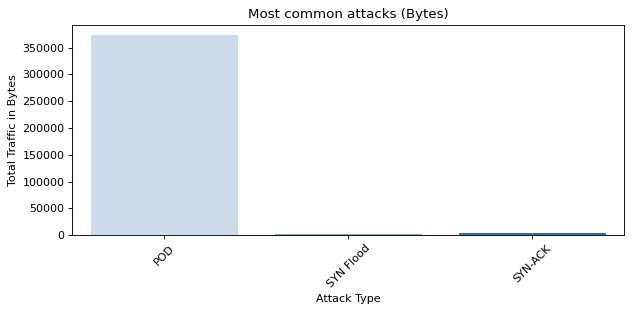

In [7]:
# Group by attack type and sum the packet sizes
traffic_by_attack = df_attacks.groupby('Attack Type')['Packet Size'].sum()

# Set the figure size and resolution (DPI)
plt.figure(figsize=(8, 4), dpi=80)  # Smaller figure size and DPI to prevent large image

# Create the bar plot
sns.barplot(x=traffic_by_attack.index, y=traffic_by_attack.values, palette='Blues')

# Add labels and title
plt.title('Most common attacks (Bytes)')
plt.xlabel('Attack Type')
plt.ylabel('Total Traffic in Bytes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust the layout to fit the figure
plt.tight_layout()

# Display the plot
plt.show()
